# **EXPLORATORY DATA ANALYSIS (EDA) OF THE DATASET**

## Import Libraries

In [ ]:
%%capture
!pip install pymorphy2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import nltk
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re
import string
import random
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import json
from pymorphy2 import MorphAnalyzer
import pymorphy2
from nltk.tokenize import word_tokenize

In [ ]:
%%capture
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [ ]:
%%capture
#title Record Each Cell's Execution Time
!pip install ipython-autotime
%load_ext autotime

time: 525 µs (started: 2024-05-23 11:17:03 +00:00)


## Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 39 s (started: 2024-05-02 04:30:34 +00:00)


## Load the Dataset

In [ ]:
import os
import urllib.request
import zipfile
import io

# Define the URLs for the datasets
TASK2PATH = {
    "CoLA": 'https://dl.fbaipublicfiles.com/glue/data/CoLA.zip',
    "SST": 'https://dl.fbaipublicfiles.com/glue/data/SST-2.zip',
    "QQP": 'https://dl.fbaipublicfiles.com/glue/data/QQP-clean.zip',
    "STS": 'https://dl.fbaipublicfiles.com/glue/data/STS-B.zip',
    "MNLI": 'https://dl.fbaipublicfiles.com/glue/data/MNLI.zip',
    "QNLI": 'https://dl.fbaipublicfiles.com/glue/data/QNLIv2.zip',
    "RTE": 'https://dl.fbaipublicfiles.com/glue/data/RTE.zip',
    "WNLI": 'https://dl.fbaipublicfiles.com/glue/data/WNLI.zip',
    "diagnostic": 'https://dl.fbaipublicfiles.com/glue/data/AX.tsv'
}

MRPC_TRAIN = 'https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt'
MRPC_TEST = 'https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt'

def download_and_extract(task, data_dir):
    print(f"Downloading and extracting {task}...")
    data_file = f"{task}.zip"
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
    with zipfile.ZipFile(data_file, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(data_file)
    print(f"\tCompleted {task}!")

def format_mrpc(data_dir):
    print("Processing MRPC...")
    mrpc_dir = os.path.join(data_dir, "MRPC")
    if not os.path.exists(mrpc_dir):
        os.makedirs(mrpc_dir)

    mrpc_train_file = os.path.join(mrpc_dir, "msr_paraphrase_train.txt")
    mrpc_test_file = os.path.join(mrpc_dir, "msr_paraphrase_test.txt")
    urllib.request.urlretrieve(MRPC_TRAIN, mrpc_train_file)
    urllib.request.urlretrieve(MRPC_TEST, mrpc_test_file)

    with io.open(mrpc_test_file, encoding='utf-8') as data_fh, \
            io.open(os.path.join(mrpc_dir, "test.tsv"), 'w', encoding='utf-8') as test_fh:
        header = data_fh.readline()
        test_fh.write("index\t#1 ID\t#2 ID\t#1 String\t#2 String\n")
        for idx, row in enumerate(data_fh):
            label, id1, id2, s1, s2 = row.strip().split('\t')
            test_fh.write(f"{idx}\t{id1}\t{id2}\t{s1}\t{s2}\n")

    print("\tCompleted MRPC!")

def download_diagnostic(data_dir):
    print("Downloading and extracting diagnostic...")
    diagnostic_dir = os.path.join(data_dir, "diagnostic")
    if not os.path.exists(diagnostic_dir):
        os.makedirs(diagnostic_dir)
    data_file = os.path.join(diagnostic_dir, "diagnostic.tsv")
    urllib.request.urlretrieve(TASK2PATH["diagnostic"], data_file)
    print("\tCompleted diagnostic!")

# Set the directory to save data
data_dir = '/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/ods_nlp_itmo/article/glue_data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# List of tasks to download
tasks = ["CoLA", "SST", "QQP", "STS", "MNLI", "QNLI", "RTE", "WNLI", "MRPC", "diagnostic"]

# Download and extract each task
for task in tasks:
    if task == 'MRPC':
        format_mrpc(data_dir)
    elif task == 'diagnostic':
        download_diagnostic(data_dir)
    else:
        download_and_extract(task, data_dir)

print("All tasks downloaded and extracted.")

	Completed CoLA!
	Completed SST!
	Completed QQP!
	Completed STS!
	Completed MNLI!
	Completed QNLI!
	Completed RTE!
	Completed WNLI!
Processing MRPC...
	Completed MRPC!
	Completed diagnostic!
All tasks downloaded and extracted.


### Importing train and tests datasets

In [ ]:
DATASET_ROOT = "/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/ods_nlp_itmo/article/glue_data"
TASKS = ["SST-2", "CoLA"]
SPLIT_NAMES = ["train", "test", "dev"]
FILE_EXTENSION = ".tsv"

In [ ]:
def read_tsv_file(path):
    return pd.read_csv(path, sep="\t")

def convert_to_csv(df, output_path):
    df.to_csv(output_path, index=False)

In [ ]:
for task in TASKS:
    task_root = f"{DATASET_ROOT}/{task}"
    for split in SPLIT_NAMES:
        input_path = f"{task_root}/{split}{FILE_EXTENSION}"
        output_path = f"{task_root}/{split}.csv"
        df = read_tsv_file(input_path)
        convert_to_csv(df, output_path)

In [ ]:
sst2_train_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/ods_nlp_itmo/article/glue_data/SST-2/train.csv")
sst2_test_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/ods_nlp_itmo/article/glue_data/SST-2/test.csv")
sst2_dev_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/ods_nlp_itmo/article/glue_data/SST-2/dev.csv")

#cola_train_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/ods_nlp_itmo/article/glue_data/CoLA/train.csv", header=None, names=["code", "label", "start", "sentence"])
#cola_test_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/ods_nlp_itmo/article/glue_data/CoLA/test.csv")
#cola_dev_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/ods_nlp_itmo/article/glue_data/CoLA/dev.csv", header=None, names=["code", "label", "start", "sentence"])

time: 334 ms (started: 2024-05-23 11:23:58 +00:00)


We need text classification for titles and for news texts.

In [ ]:
df_text = sst2_train_df.copy()
df_text = sst2_train_df[['sentence', 'label']]
test_text = sst2_test_df.copy()
valid_text = sst2_dev_df.copy()

time: 17.7 ms (started: 2024-05-23 11:31:22 +00:00)


# **Working with text**

## Analyze the Classes (Sentiments)

### Topic List

In [ ]:
sentiment_list = df_text.label.unique()
print("Sentiments:\n", sentiment_list)

Sentiments:
 [0 1]
time: 2.64 ms (started: 2024-05-23 11:31:26 +00:00)


In [ ]:
number_of_sentiments = len(sentiment_list)
print("Number of Topics: ",number_of_sentiments)

Number of Topics:  2
time: 757 µs (started: 2024-05-23 11:31:29 +00:00)


### Number of texts per Sentiments

In [ ]:
df_text.label.value_counts()

label
1    37569
0    29780
Name: count, dtype: int64

time: 17 ms (started: 2024-05-23 11:31:51 +00:00)


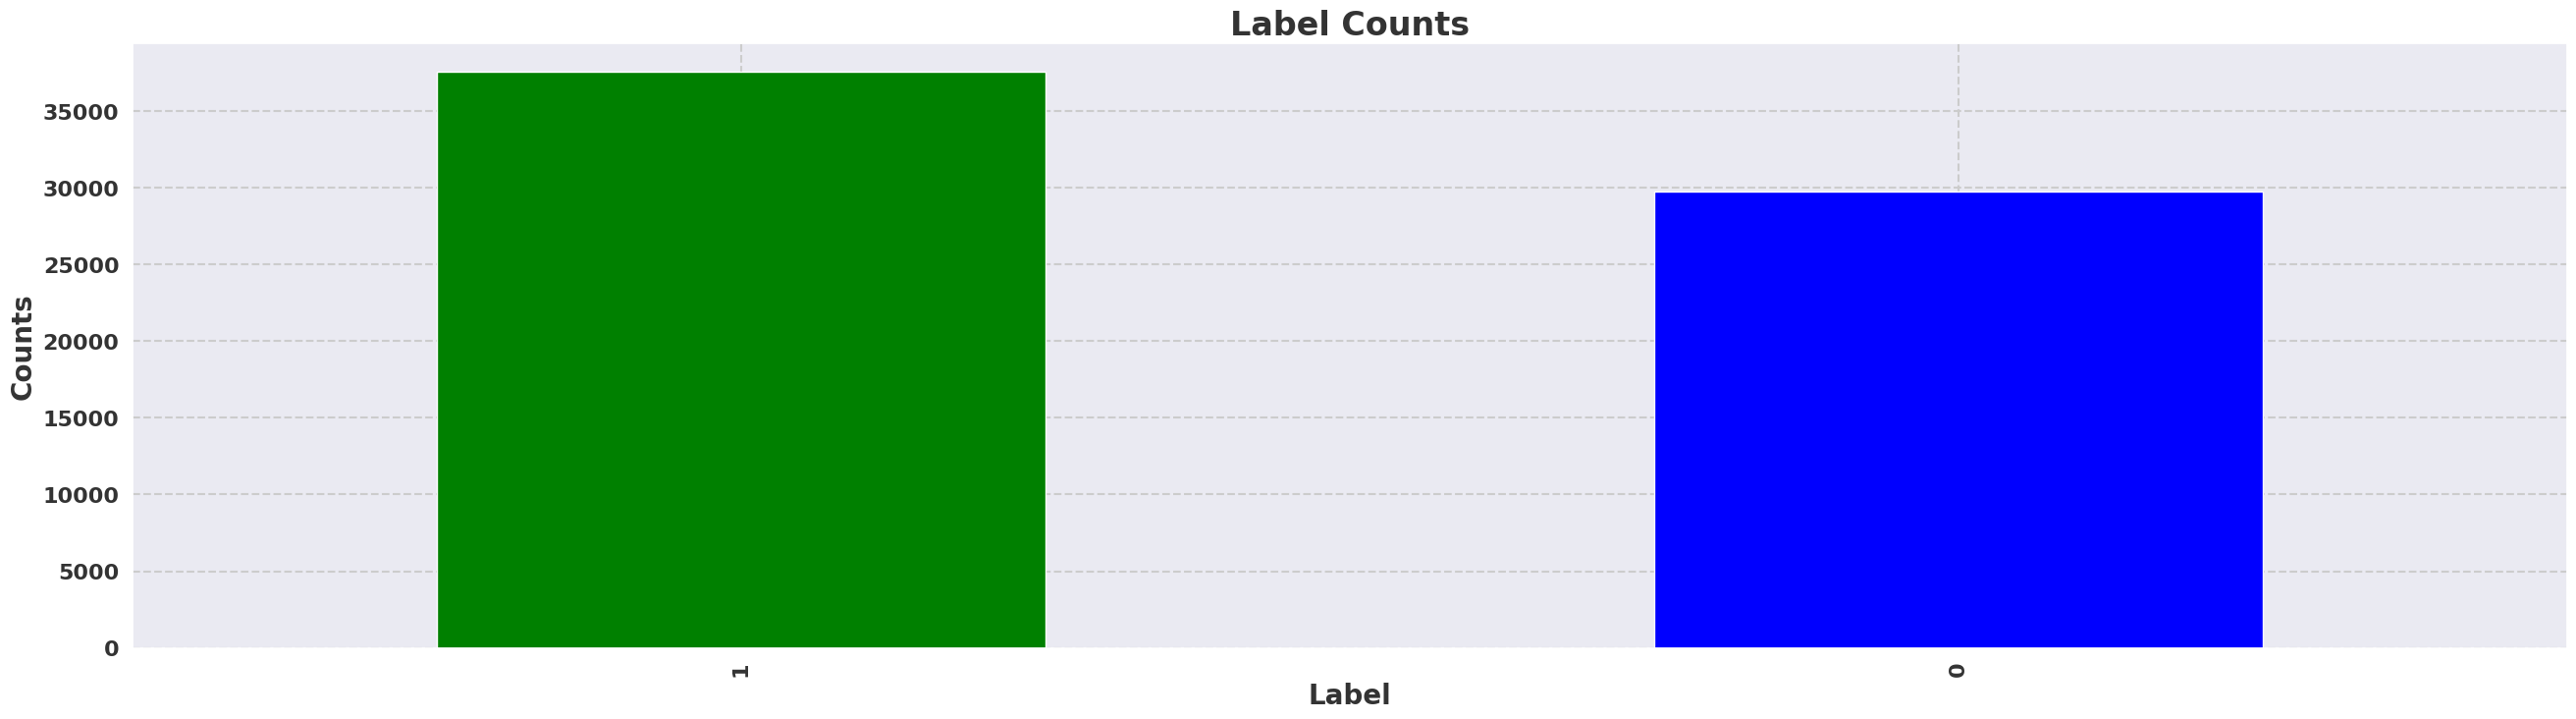

time: 1.07 s (started: 2024-05-23 11:33:10 +00:00)


In [ ]:
import seaborn as sns

sns.set_style("whitegrid")

sns.set(font_scale=2)

count_plot = df_text.label.value_counts().plot.bar(x="Label", y="Texts", figsize=(32, 8), color=['green', 'blue', 'red'])

plt.title('Label Counts', fontsize=24, fontweight='bold', color='#333333')

plt.xlabel('Label', fontsize=20, fontweight='bold', color='#333333')
plt.ylabel('Counts', fontsize=20, fontweight='bold', color='#333333')

plt.xticks(fontsize=16, fontweight='bold', color='#333333')
plt.yticks(fontsize=16, fontweight='bold', color='#333333')

plt.grid(linestyle='--', linewidth=1.5, color='#cccccc')

plt.show()

## Analyze News (Text)

### Calculate the number of words in each reviews

In [ ]:
df_text['words'] = df_text['sentence'].apply(lambda x: len(word_tokenize(x)))

time: 11.3 s (started: 2024-05-23 11:34:30 +00:00)


In [ ]:
df_text.tail()

,sentence,label,words
67344,a delightful comedy,1,3
67345,"anguish , anger and frustration",0,5
67346,"at achieving the modest , crowd-pleasing goals...",1,11
67347,a patient viewer,1,3
67348,"this new jangle of noise , mayhem and stupidit...",0,18


time: 16.8 ms (started: 2024-05-23 11:36:09 +00:00)


### Review Length in terms of Number of Words

In [ ]:
df_text['words'].describe()

count    67349.000000
mean         9.413711
std          8.078156
min          1.000000
25%          3.000000
50%          7.000000
75%         13.000000
max         53.000000
Name: words, dtype: float64

time: 13.3 ms (started: 2024-05-23 11:36:39 +00:00)


### Review Length in terms of Number of Words per Topic

In [ ]:
df_text.groupby(['label'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,29780.0,9.887811,8.162102,1.0,3.0,8.0,14.0,53.0
1,37569.0,9.037904,7.991138,1.0,3.0,6.0,13.0,52.0


time: 94.6 ms (started: 2024-05-23 11:37:06 +00:00)


### Number of short reviews

We can check the number of short reviews by comparing a threshold:

In [ ]:
min_review_size = 1
df_text[df_text['words']>min_review_size].count()

sentence    63082
label       63082
words       63082
dtype: int64

time: 38.8 ms (started: 2024-05-23 11:38:11 +00:00)


### for DL Conv1D

In [ ]:
min_review_size = 1
max_review_size = 53

time: 764 µs (started: 2024-05-23 11:39:11 +00:00)


In [ ]:
data = df_text[df_text['words']>=min_review_size]

time: 14 ms (started: 2024-05-23 11:40:14 +00:00)


## Analyze the Vocabulary



In [ ]:
vocab = {word.lower() for sentence in [x.split() for x in data['sentence'].tolist()] for word in sentence}
print("Number of distinct words in raw data:", len(vocab))

Number of distinct words in raw data: 14816
time: 513 ms (started: 2024-05-23 11:40:49 +00:00)


In [ ]:
vocab_size = len(vocab)

time: 653 µs (started: 2024-05-23 11:41:28 +00:00)


### Count the frequency of words in the raw dataset

In [ ]:
word_freq = (
    data.sentence.str.split(expand=True)
    .stack()
    .value_counts()
    .reset_index(name='freq')
    .rename(columns={'index': 'word'})
)

time: 4.45 s (started: 2024-05-23 11:42:18 +00:00)


# PREPARE THE DATASET

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67349 entries, 0 to 67348
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  67349 non-null  object
 1   label     67349 non-null  int64 
 2   words     67349 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB
time: 38.6 ms (started: 2024-05-23 11:43:10 +00:00)


In [ ]:
data.describe()

,label,words
count,67349.000000,67349.000000
mean,0.557826,9.413711
std,0.496649,8.078156
min,0.000000,1.000000
25%,0.000000,3.000000
50%,1.000000,7.000000
75%,1.000000,13.000000
max,1.000000,53.000000


time: 41.1 ms (started: 2024-05-23 11:43:18 +00:00)


In [ ]:
data = data.sample(frac=1)

time: 12.3 ms (started: 2024-05-23 11:43:24 +00:00)


In [ ]:
data['sentiment'] = np.where(data['label'] == 0, 'negative', 'positive')

time: 34.3 ms (started: 2024-05-23 11:47:57 +00:00)


In [ ]:
data["sentiment"] = data["sentiment"].astype('category')
data["label"] = data["label"].astype('int')
data.dtypes

sentence       object
label           int64
words           int64
sentiment    category
dtype: object

time: 15.6 ms (started: 2024-05-23 11:49:02 +00:00)


In [ ]:
data["sentiment_id"] = data["sentiment"].cat.codes
data.tail()

,sentence,label,words,sentiment,sentiment_id
32442,or `` suck '',0,4,negative,0
32720,mindless without being the peak of all things ...,0,9,negative,0
20461,eschews the previous film 's historical panora...,0,16,negative,0
9858,", having sucked dry the undead action flick fo...",0,27,negative,0
11156,the imax screen enhances the personal touch of...,1,11,positive,1


time: 45.8 ms (started: 2024-05-23 11:50:34 +00:00)


## Build a Dictionary for id to text sentiments:

In [ ]:
id_to_sentiment = pd.Series(data.sentiment.values,index=data.sentiment_id).to_dict()
id_to_sentiment

{1: 'positive', 0: 'negative'}

time: 106 ms (started: 2024-05-23 11:50:52 +00:00)


## Build another Dictionary for sentiments to text:

In [ ]:
sentiment_to_id = {v:k for k,v in id_to_sentiment.items()}
sentiment_to_id

{'positive': 1, 'negative': 0}

time: 3.29 ms (started: 2024-05-23 12:22:10 +00:00)


### Check the conversions:

In [ ]:
!ls

'01 Text Classification with Deep Learning Models.ipynb'   glue_data
time: 129 ms (started: 2024-05-23 12:22:03 +00:00)


In [ ]:
import pickle
with open('id_to_sentiment.pkl', 'wb') as fp:
    pickle.dump(id_to_sentiment, fp)

time: 31.9 ms (started: 2024-05-23 12:22:22 +00:00)


In [ ]:
with open('id_to_sentiment.pkl', 'rb') as fp:
    id_to_sentiment_loaded = pickle.load(fp)

time: 4.31 ms (started: 2024-05-23 12:22:27 +00:00)


In [ ]:
id_to_sentiment_loaded

{1: 'positive', 0: 'negative'}

time: 3.43 ms (started: 2024-05-23 12:22:31 +00:00)


In [ ]:
number_of_sentiment = len(sentiment_to_id)
print(f"number of sentiments: {number_of_sentiment}")

number of sentiments: 2
time: 736 µs (started: 2024-05-23 12:22:38 +00:00)


### **Test, Train & Validation Datasets**

In [ ]:
train_text, test_text = train_test_split(data, test_size=0.2, random_state=23052024)

train_features = train_text['sentence']
train_target = train_text['label']

val_features = valid_text['sentence']
val_target = valid_text['label']

test_features = test_text['sentence']
test_target = test_text['label']

time: 70.6 ms (started: 2024-05-23 12:52:40 +00:00)


In [ ]:
print("Train Data Set size: ", len(train_features))
print("Validation Data Set size: ", len(val_features))
print("Test Data Set size: ", len(test_features))

Train Data Set size:  53879
Validation Data Set size:  872
Test Data Set size:  13470
time: 16.3 ms (started: 2024-05-23 12:52:41 +00:00)


## Build the Train TensorFlow Datasets



In [ ]:
same_elements = train_features.equals(val_features)

print('Same elements:', same_elements)

Same elements: False
time: 795 µs (started: 2024-05-23 12:46:11 +00:00)


In [ ]:
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_features.values, tf.string)
)

time: 17.3 ms (started: 2024-05-23 12:46:13 +00:00)


In [ ]:
train_sentiment_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_target.values, tf.int64),
)

time: 5.62 ms (started: 2024-05-23 12:46:15 +00:00)


In [ ]:
train_text_ds_raw.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

time: 3.19 ms (started: 2024-05-23 12:46:17 +00:00)


## Decide the dictionary size and the review size

For preprocessing the text, we need to decide the **dictionary (vocab) size** and the **maximum review (text) size**.

We will just take the `min` and `max`.

In [ ]:
vocab_size = vocab_size
max_len = max_review_size

time: 537 µs (started: 2024-05-23 12:46:21 +00:00)


## Prepare the Keras Text Vectorization layer



In [ ]:
import string

@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_string):
    """ Preprocess English text """
    # Convert text to lowercase
    no_uppercased = tf.strings.lower(input_string, encoding='utf-8')
    # Remove HTML tags
    no_html_tags = tf.strings.regex_replace(no_uppercased, "<[^>]+>", " ")
    # Remove email addresses
    no_emails = tf.strings.regex_replace(no_html_tags, r'\S+@\S+', ' ')
    # Remove digits
    no_digits = tf.strings.regex_replace(no_emails, r"\d", " ")
    # Remove punctuation
    no_punctuations = tf.strings.regex_replace(no_digits, f"([{string.punctuation}])", r" ")
    # Remove newlines
    no_newlines = tf.strings.regex_replace(no_punctuations, "\n", " ")
    # Remove extra spaces
    no_extra_space = tf.strings.regex_replace(no_newlines, " +", " ")
    return no_extra_space

time: 1.14 ms (started: 2024-05-23 12:46:24 +00:00)


In [ ]:
input_string = """
<html>
<head>
<title>or `` suck ''</title>
</head>
<body>
<p>This is an example text with some punctuation: test, test, test.</p>
<p>It also contains numbers, for example 123456.</p>
<p>And some examples - _ for removal: sample1 and sample2.</p>
<p>Email address: example@example.com</p>
</body>
</html>
"""

print("input:  ", input_string)
output_string= custom_standardization(input_string)
print("output: ", output_string.numpy().decode("utf-8"))

input:   
<html>
<head>
<title>or `` suck ''</title>
</head>
<body>
<p>This is an example text with some punctuation: test, test, test.</p>
<p>It also contains numbers, for example 123456.</p>
<p>And some examples - _ for removal: sample1 and sample2.</p>
<p>Email address: example@example.com</p>
</body>
</html>

output:   or suck this is an example text with some punctuation test test test it also contains numbers for example and some examples for removal sample and sample email address 
time: 4.34 ms (started: 2024-05-23 12:33:39 +00:00)


### Build a TextVectorization layer

In [ ]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=max_len,
)

time: 10.6 ms (started: 2024-05-23 12:46:47 +00:00)


### Adopt the Text Vectorization layer

In [ ]:
vectorize_layer.adapt(train_text_ds_raw)
vocab = vectorize_layer.get_vocabulary()

time: 1min 7s (started: 2024-05-23 12:47:39 +00:00)


### Check the dictionary (vocab) and preprocessing

Let's see some example conversions:

### Save & Load the adopted TextVectorization layer

In [ ]:
%cd models/
%ls

/content/drive/MyDrive/Colab_Notebooks/nlp_with_python/ods_nlp_itmo/article/models
time: 112 ms (started: 2024-05-23 12:37:29 +00:00)


In [ ]:
vectorizer_model = tf.keras.models.Sequential()
vectorizer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
vectorizer_model.add(vectorize_layer)
vectorizer_model.summary()

filepath = "vectorize_layer_model"
vectorizer_model.save(filepath, save_format="tf")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 53)                0         
 Vectorization)                                                  
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


time: 665 ms (started: 2024-05-23 12:50:07 +00:00)


In [ ]:
%ls

vectorize_layer_model/
time: 107 ms (started: 2024-05-23 12:50:11 +00:00)


In [ ]:
# Load the saved model
loaded_vectorizer_model = tf.keras.models.load_model(filepath)
loaded_vectorizer_layer = loaded_vectorizer_model.layers[0]

time: 251 ms (started: 2024-05-23 12:50:14 +00:00)


### Check the loaded Text Vectorization layer

In [ ]:
loaded_vocab = loaded_vectorizer_layer.get_vocabulary()
print("original vocab has the ", len(vocab)," entries")
print("loaded_vectorizer_layer vocab has the ", len(loaded_vocab)," entries")
print("original vocab: ", vocab[:10])
print("loaded vocab  : ", loaded_vocab[:10])

original vocab has the  13554  entries
loaded_vectorizer_layer vocab has the  13554  entries
original vocab:  ['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 's', 'is', 'that']
loaded vocab  :  ['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 's', 'is', 'that']
time: 57.8 ms (started: 2024-05-23 12:50:17 +00:00)


## Preprocess the Train & Test Data by the adopted TextVecorization Layer

In [ ]:
prepare_lm_inputs_labels = lambda text: tf.squeeze(vectorize_layer(tf.expand_dims(text, -1)))

time: 738 µs (started: 2024-05-23 12:50:20 +00:00)


### Process the Train Data

In [ ]:
train_text_ds = train_text_ds_raw.map(prepare_lm_inputs_labels,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

time: 49.7 ms (started: 2024-05-23 12:50:23 +00:00)


In [ ]:
train_text_ds.element_spec

TensorSpec(shape=<unknown>, dtype=tf.int64, name=None)

time: 3.64 ms (started: 2024-05-23 12:50:24 +00:00)


In [ ]:
train_ds = tf.data.Dataset.zip(
    (train_text_ds,train_sentiment_ds_raw)
)

time: 3.49 ms (started: 2024-05-23 12:50:52 +00:00)


In [ ]:
train_size = train_ds.cardinality().numpy()
print("Train size: ", train_size)

Train size:  53879
time: 2.17 ms (started: 2024-05-23 12:50:54 +00:00)


### Process the Validation Data

In [ ]:
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(val_features.values, tf.string)
)

time: 4.07 ms (started: 2024-05-23 12:50:59 +00:00)


In [ ]:
val_sentiment_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(val_target.values, tf.int64),
)

time: 4.49 ms (started: 2024-05-23 12:51:02 +00:00)


In [ ]:
val_text_ds = val_text_ds_raw.map(prepare_lm_inputs_labels,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

time: 65.7 ms (started: 2024-05-23 12:51:06 +00:00)


In [ ]:
val_ds = tf.data.Dataset.zip(
    (val_text_ds, val_sentiment_ds_raw)
)

time: 3.19 ms (started: 2024-05-23 12:51:11 +00:00)


### Process the Test Data

In [ ]:
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_features.values, tf.string)
)

time: 13.6 ms (started: 2024-05-23 12:53:11 +00:00)


In [ ]:
test_sentiment_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_target.values, tf.int64),
)

time: 19.4 ms (started: 2024-05-23 12:53:20 +00:00)


In [ ]:
test_text_ds = test_text_ds_raw.map(prepare_lm_inputs_labels,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

time: 51.2 ms (started: 2024-05-23 12:53:28 +00:00)


In [ ]:
test_ds = tf.data.Dataset.zip(
    (test_text_ds, test_sentiment_ds_raw)
)

time: 5.62 ms (started: 2024-05-23 12:53:34 +00:00)


In [ ]:
test_size = test_ds.cardinality().numpy()
print("Test size: ", test_size)

Test size:  13470
time: 3.38 ms (started: 2024-05-23 12:53:38 +00:00)


## Finalize the TensorFlow Data Pipeline

In [ ]:
batch_size=64
AUTOTUNE=tf.data.experimental.AUTOTUNE

train_ds=train_ds.shuffle(buffer_size=train_size)
train_ds=train_ds.batch(batch_size=batch_size,drop_remainder=True)
train_ds=train_ds.cache()
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds=val_ds.shuffle(buffer_size=train_size)
val_ds=val_ds.batch(batch_size=batch_size,drop_remainder=True)
val_ds=val_ds.cache()
val_ds = val_ds.prefetch(AUTOTUNE)

test_ds=test_ds.shuffle(buffer_size=train_size)
test_ds=test_ds.batch(batch_size=batch_size,drop_remainder=True)
test_ds=test_ds.cache()
test_ds = test_ds.prefetch(AUTOTUNE)

time: 46.9 ms (started: 2024-05-23 12:53:47 +00:00)


In [ ]:
train_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
 TensorSpec(shape=(64,), dtype=tf.int64, name=None))

time: 3.93 ms (started: 2024-05-23 12:53:54 +00:00)


# TEXT CLASSIFICATION WITH AN EMBEDDING LAYER IN A FEED FORWARD NETWORK

## Keras Embedding Layer

In [ ]:
class FFNModel:
    def __init__(self, max_len, vocab_size, embed_dim=16, feed_forward_dim=64, number_of_sentiment=3):
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.feed_forward_dim = feed_forward_dim
        self.number_of_sentiment = number_of_sentiment

    def build_model(self):
        inputs_tokens = layers.Input(shape=(self.max_len,), dtype=tf.int32)
        embedding_layer = layers.Embedding(input_dim=self.vocab_size,
                                           output_dim=self.embed_dim,
                                           input_length=self.max_len)
        x = embedding_layer(inputs_tokens)
        x = layers.Flatten()(x)
        dense_layer = layers.Dense(self.feed_forward_dim, activation='relu')
        x = dense_layer(x)
        x = layers.Dropout(.5)(x)
        outputs = layers.Dense(self.number_of_sentiment)(x)

        model = keras.Model(inputs=inputs_tokens, outputs=outputs, name='model_FFN')
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()
        model.compile(optimizer="adam", loss=loss_fn, metrics=metric_fn)

        return model

model_builder = FFNModel(max_len, vocab_size)
model_FFN = model_builder.build_model()

time: 111 ms (started: 2024-05-23 12:54:11 +00:00)


In [ ]:
model_FFN.summary()

Model: "model_FFN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 53)]              0         
                                                                 
 embedding (Embedding)       (None, 53, 16)            237056    
                                                                 
 flatten (Flatten)           (None, 848)               0         
                                                                 
 dense (Dense)               (None, 64)                54336     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 291587 (1.11 MB)
Trainable params: 291587 (

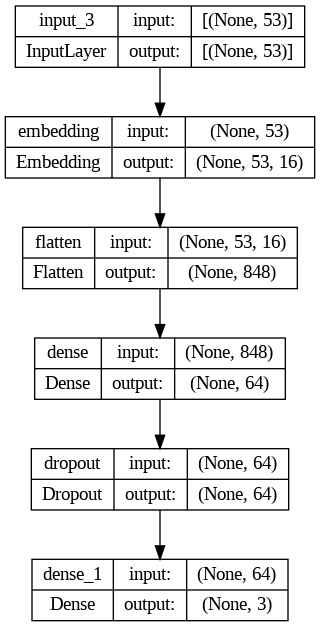

time: 379 ms (started: 2024-05-23 12:54:17 +00:00)


In [ ]:
tf.keras.utils.plot_model(model_FFN,show_shapes=True)

## Train

In [ ]:
train_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.int64, name=None),
 TensorSpec(shape=(64,), dtype=tf.int64, name=None))

time: 3.43 ms (started: 2024-05-23 12:54:21 +00:00)


In [ ]:
history = model_FFN.fit(train_ds, validation_data=val_ds, verbose=2, epochs=7)

Epoch 1/7
841/841 - 11s - loss: 0.4974 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.4591 - val_sparse_categorical_accuracy: 0.8065 - 11s/epoch - 13ms/step
Epoch 2/7
841/841 - 4s - loss: 0.2262 - sparse_categorical_accuracy: 0.9152 - val_loss: 0.5359 - val_sparse_categorical_accuracy: 0.8053 - 4s/epoch - 4ms/step
Epoch 3/7
841/841 - 4s - loss: 0.1466 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.6610 - val_sparse_categorical_accuracy: 0.8077 - 4s/epoch - 5ms/step
Epoch 4/7
841/841 - 5s - loss: 0.0990 - sparse_categorical_accuracy: 0.9681 - val_loss: 0.7915 - val_sparse_categorical_accuracy: 0.7969 - 5s/epoch - 6ms/step
Epoch 5/7
841/841 - 4s - loss: 0.0692 - sparse_categorical_accuracy: 0.9784 - val_loss: 0.8912 - val_sparse_categorical_accuracy: 0.8089 - 4s/epoch - 4ms/step
Epoch 6/7
841/841 - 4s - loss: 0.0521 - sparse_categorical_accuracy: 0.9841 - val_loss: 1.0408 - val_sparse_categorical_accuracy: 0.8113 - 4s/epoch - 5ms/step
Epoch 7/7
841/841 - 5s - loss: 0.0413 - spa

Let's observe the **accuracy** and the **loss** values during the training at each epoch:

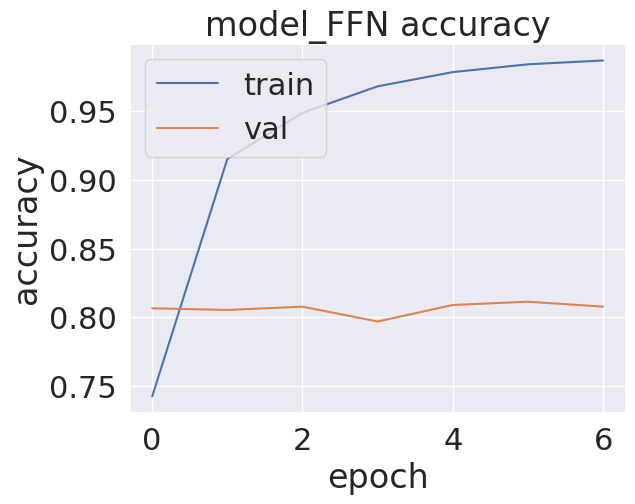

time: 286 ms (started: 2024-05-23 12:55:18 +00:00)


In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model_FFN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

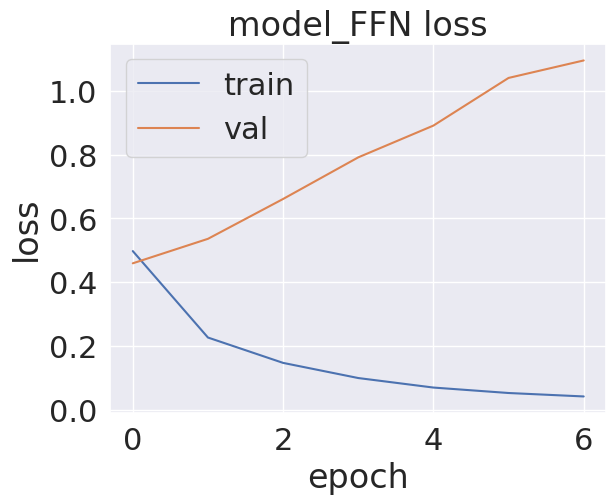

time: 288 ms (started: 2024-05-23 12:55:25 +00:00)


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_FFN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Save the trained model

In [ ]:
tf.keras.models.save_model(model_FFN, 'MultiClassTextClassification_FFN')

time: 1.65 s (started: 2024-05-23 12:55:51 +00:00)


## Test

We can test the trained model with the test dataset:

In [ ]:
loss, accuracy = model_FFN.evaluate(test_ds)
print("Test accuracy: ", accuracy)

210/210 [==============================] - 1s 2ms/step - loss: 0.4415 - sparse_categorical_accuracy: 0.9013
Test accuracy:  0.9012649059295654
time: 2.57 s (started: 2024-05-23 12:55:56 +00:00)


## Predictions

We can use the **trained model** `predict()` method to **predict** the class of the given reviews as follows:

In [ ]:
preds = model_FFN.predict(test_ds)
preds = preds.argmax(axis=1)

210/210 [==============================] - 0s 2ms/step
time: 450 ms (started: 2024-05-23 14:50:26 +00:00)


We can also get the **actual (true)** class of the given reviews as follows:

In [ ]:
actuals = test_ds.unbatch().map(lambda x,y: y)
actuals=list(actuals.as_numpy_iterator())

time: 5.15 s (started: 2024-05-23 14:50:29 +00:00)


By comparing the ***`preds`*** and the ***`actuals`*** values, we can **measure** the model performance as below.

## Classification Report

Since we are dealing with a **classification**, it is a good idea to generate a **classification report** to observe the performance of the model for ***each class***. We can use the [SKLearn `classification_report()` method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to build a text report showing the main classification **metrics**.

Report is the summary of the **precision, recall, F1** score for ***each class***.

The reported ***averages*** include:
* **macro average** (averaging the unweighted mean per label),
* **weighted average** (averaging the support-weighted mean per label),  
* **sample average** (only for multilabel classification),
* **micro average** (averaging the total true positives, false negatives and false positives) is only shown for multi-label or multi-class with a subset of classes, because it corresponds to accuracy otherwise and would be the same for all metrics.

In [ ]:
from sklearn import metrics
print(metrics.classification_report(actuals, preds, digits=4))

              precision    recall  f1-score   support

           0     0.8924    0.8813    0.8868      5899
           1     0.9081    0.9169    0.9124      7541

    accuracy                         0.9013     13440
   macro avg     0.9002    0.8991    0.8996     13440
weighted avg     0.9012    0.9013    0.9012     13440

time: 39.9 ms (started: 2024-05-23 14:50:37 +00:00)


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actuals, preds)
cm_df = pd.DataFrame(cm, index = id_to_sentiment.values() ,columns = id_to_sentiment.values())

time: 11.4 ms (started: 2024-05-23 14:50:43 +00:00)


Below, you can observe the distribution of predictions over the classes.

In [ ]:
cm_df

,positive,negative
positive,5199,700
negative,627,6914


time: 17 ms (started: 2024-05-23 14:50:46 +00:00)


In [ ]:
%%capture
!pip install ipywidgets

time: 6.54 s (started: 2024-05-23 12:57:00 +00:00)


interactive(children=(Output(),), _dom_classes=('widget-interact',))

<function __main__.update_heatmap(vmin, vmax)>

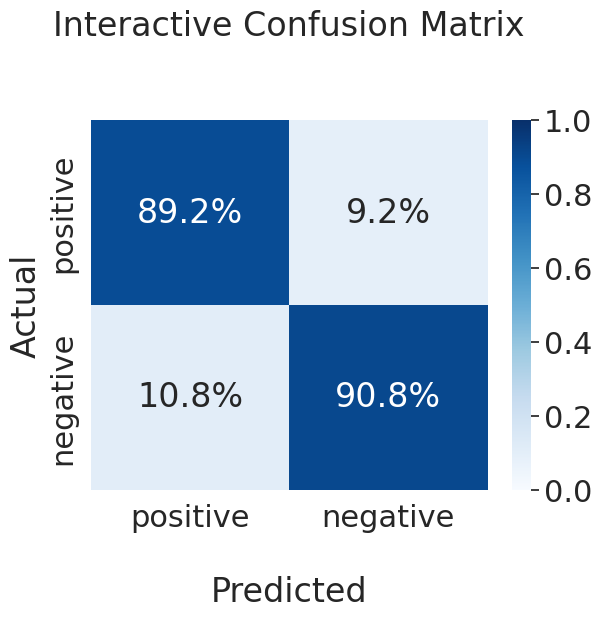

time: 3.2 s (started: 2024-05-23 12:57:08 +00:00)


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

def update_heatmap(vmin, vmax):
    ax = sns.heatmap(cm_df / np.sum(cm_df), vmin=vmin, vmax=vmax, annot=True, fmt='.1%', cmap='Blues')
    ax.set_title('Interactive Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set_ticklabels(id_to_sentiment.values())
    ax.yaxis.set_ticklabels(id_to_sentiment.values())

interact(update_heatmap, vmin=fixed(0), vmax=fixed(1))

# TEXT CLASSIFICATION WITH A CONVOLUTIONAL (CONV1D) LAYER

## Let's build a model with a Conv1D layer

In [ ]:
from tensorflow.keras import layers, Model

class Conv1DModel:
    def __init__(self, vocab_size, max_len, number_of_categories):
        self.embed_dim = 16
        self.feed_forward_dim = 64
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.number_of_categories = number_of_categories

    def create_model(self):
        inputs_tokens = layers.Input(shape=(self.max_len,), dtype=tf.int32)
        embedding_layer = layers.Embedding(input_dim=self.vocab_size,
                                           output_dim=self.embed_dim,
                                           input_length=self.max_len)
        x = embedding_layer(inputs_tokens)
        x = layers.Conv1D(filters=256, kernel_size=7,
                          padding='same', activation='relu')(x)
        x = layers.Conv1D(filters=128, kernel_size=5,
                          padding='same', activation='relu')(x)
        x = layers.Conv1D(filters=128, kernel_size=3,
                          padding='same', activation='relu')(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(self.feed_forward_dim, activation='sigmoid')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.number_of_categories)(x)
        model = Model(inputs=inputs_tokens,
                      outputs=outputs, name='model_Conv1D')
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()
        model.compile(optimizer="adam", loss=loss_fn, metrics=metric_fn)
        return model


conv1d_model = Conv1DModel(vocab_size, max_len, 3)
model = conv1d_model.create_model()

time: 243 ms (started: 2024-05-23 12:57:47 +00:00)


In [ ]:
model.summary()

Model: "model_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 53)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 53, 16)            237056    
                                                                 
 conv1d (Conv1D)             (None, 53, 256)           28928     
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 128)           163968    
                                                                 
 conv1d_2 (Conv1D)           (None, 53, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 128)           0         
 D)                                                              
                                                      

In [ ]:
model.summary()

Model: "model_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 53)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 53, 16)            237056    
                                                                 
 conv1d (Conv1D)             (None, 53, 256)           28928     
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 128)           163968    
                                                                 
 conv1d_2 (Conv1D)           (None, 53, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 128)           0         
 D)                                                              
                                                      

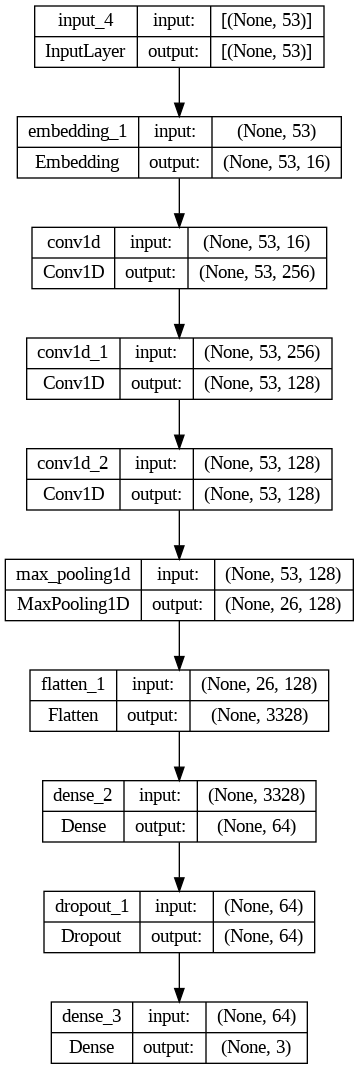

time: 95.4 ms (started: 2024-05-23 12:57:54 +00:00)


In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

## Train

In [ ]:
history=model.fit(train_ds, validation_data=val_ds ,verbose=1, epochs=25)

Epoch 1/25
841/841 [==============================] - 136s 159ms/step - loss: 0.4072 - sparse_categorical_accuracy: 0.8146 - val_loss: 0.4201 - val_sparse_categorical_accuracy: 0.8317
Epoch 2/25
841/841 [==============================] - 112s 133ms/step - loss: 0.2079 - sparse_categorical_accuracy: 0.9258 - val_loss: 0.4638 - val_sparse_categorical_accuracy: 0.8353
Epoch 3/25
841/841 [==============================] - 112s 133ms/step - loss: 0.1411 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.5477 - val_sparse_categorical_accuracy: 0.8293
Epoch 4/25
841/841 [==============================] - 112s 133ms/step - loss: 0.1004 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.6062 - val_sparse_categorical_accuracy: 0.8185
Epoch 5/25
841/841 [==============================] - 116s 138ms/step - loss: 0.0757 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.7614 - val_sparse_categorical_accuracy: 0.7957
Epoch 6/25
841/841 [==============================] - 110s 131ms/step - loss: 0.

Let's observe the **accuracy** and the **loss** values during the training:

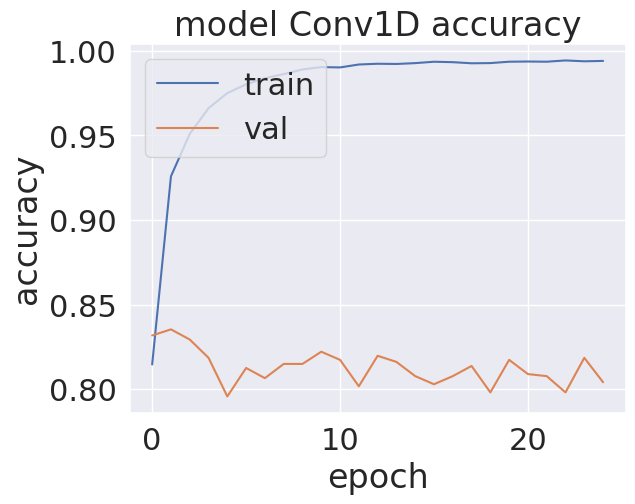

time: 286 ms (started: 2024-05-23 13:55:39 +00:00)


In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model Conv1D accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

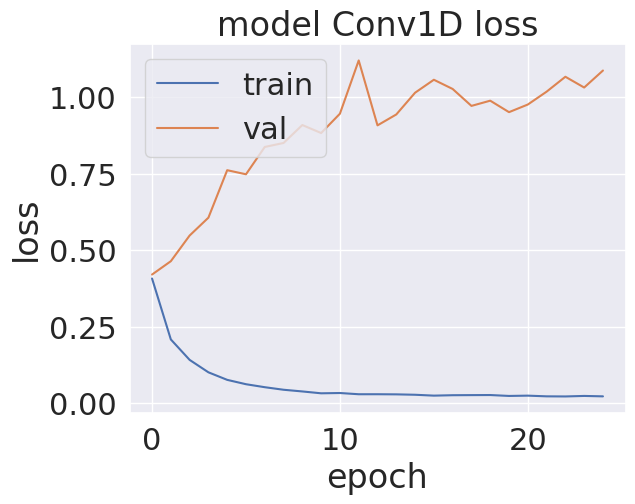

time: 288 ms (started: 2024-05-23 13:55:57 +00:00)


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Conv1D loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Save the trained model

In [ ]:
tf.keras.models.save_model(model, 'MultiClassTextClassification_Conv1D')

time: 1.2 s (started: 2024-05-23 13:56:11 +00:00)


In [ ]:
model_Conv1D=tf.keras.models.load_model('MultiClassTextClassification_Conv1D')

time: 505 ms (started: 2024-05-23 13:56:14 +00:00)


In [ ]:
model_Conv1D.summary()

Model: "model_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 53)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 53, 16)            237056    
                                                                 
 conv1d (Conv1D)             (None, 53, 256)           28928     
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 128)           163968    
                                                                 
 conv1d_2 (Conv1D)           (None, 53, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 128)           0         
 D)                                                              
                                                      

## Test

In [ ]:
loss, accuracy = model_Conv1D.evaluate(test_ds)
print("Test accuracy: ", accuracy)

210/210 [==============================] - 8s 35ms/step - loss: 0.4953 - sparse_categorical_accuracy: 0.9152
Test accuracy:  0.9151785969734192
time: 7.7 s (started: 2024-05-23 13:56:21 +00:00)


## Predictions

We can use the **trained model** `predict()` method to **predict** the class of the given reviews as follows:

In [ ]:
preds = model_Conv1D.predict(test_ds)
preds = preds.argmax(axis=1)

210/210 [==============================] - 8s 39ms/step
time: 8.51 s (started: 2024-05-23 13:56:35 +00:00)


We can also get the **actual (true)** class of the given reviews as follows:

In [ ]:
actuals = test_ds.unbatch().map(lambda x,y: y)
actuals=list(actuals.as_numpy_iterator())

time: 5.14 s (started: 2024-05-23 13:56:48 +00:00)


By comparing the ***`preds`*** and the ***`actuals`***
values, we can **measure** the model performance as below.

## Classification Report

In [ ]:
from sklearn import metrics
print(metrics.classification_report(actuals, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9112    0.8939    0.9024      5899
           1     0.9182    0.9318    0.9250      7541

    accuracy                         0.9152     13440
   macro avg     0.9147    0.9129    0.9137     13440
weighted avg     0.9151    0.9152    0.9151     13440

time: 35.7 ms (started: 2024-05-23 13:56:57 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix
# Creating  a confusion matrix,
# which compares the y_test and y_pred
cm = confusion_matrix(actuals, preds)
cm_df = pd.DataFrame(cm, index = id_to_sentiment.values() ,
                     columns = id_to_sentiment.values())

time: 10.1 ms (started: 2024-05-23 13:56:59 +00:00)


In [ ]:
cm_df

,positive,negative
positive,5273,626
negative,514,7027


time: 18 ms (started: 2024-05-23 13:57:00 +00:00)


We can also visualize the confusion matrix as the **ratios** of the predictions over the classes. The ratios on the **diagonal** are the ratios of the **correct predictions**.

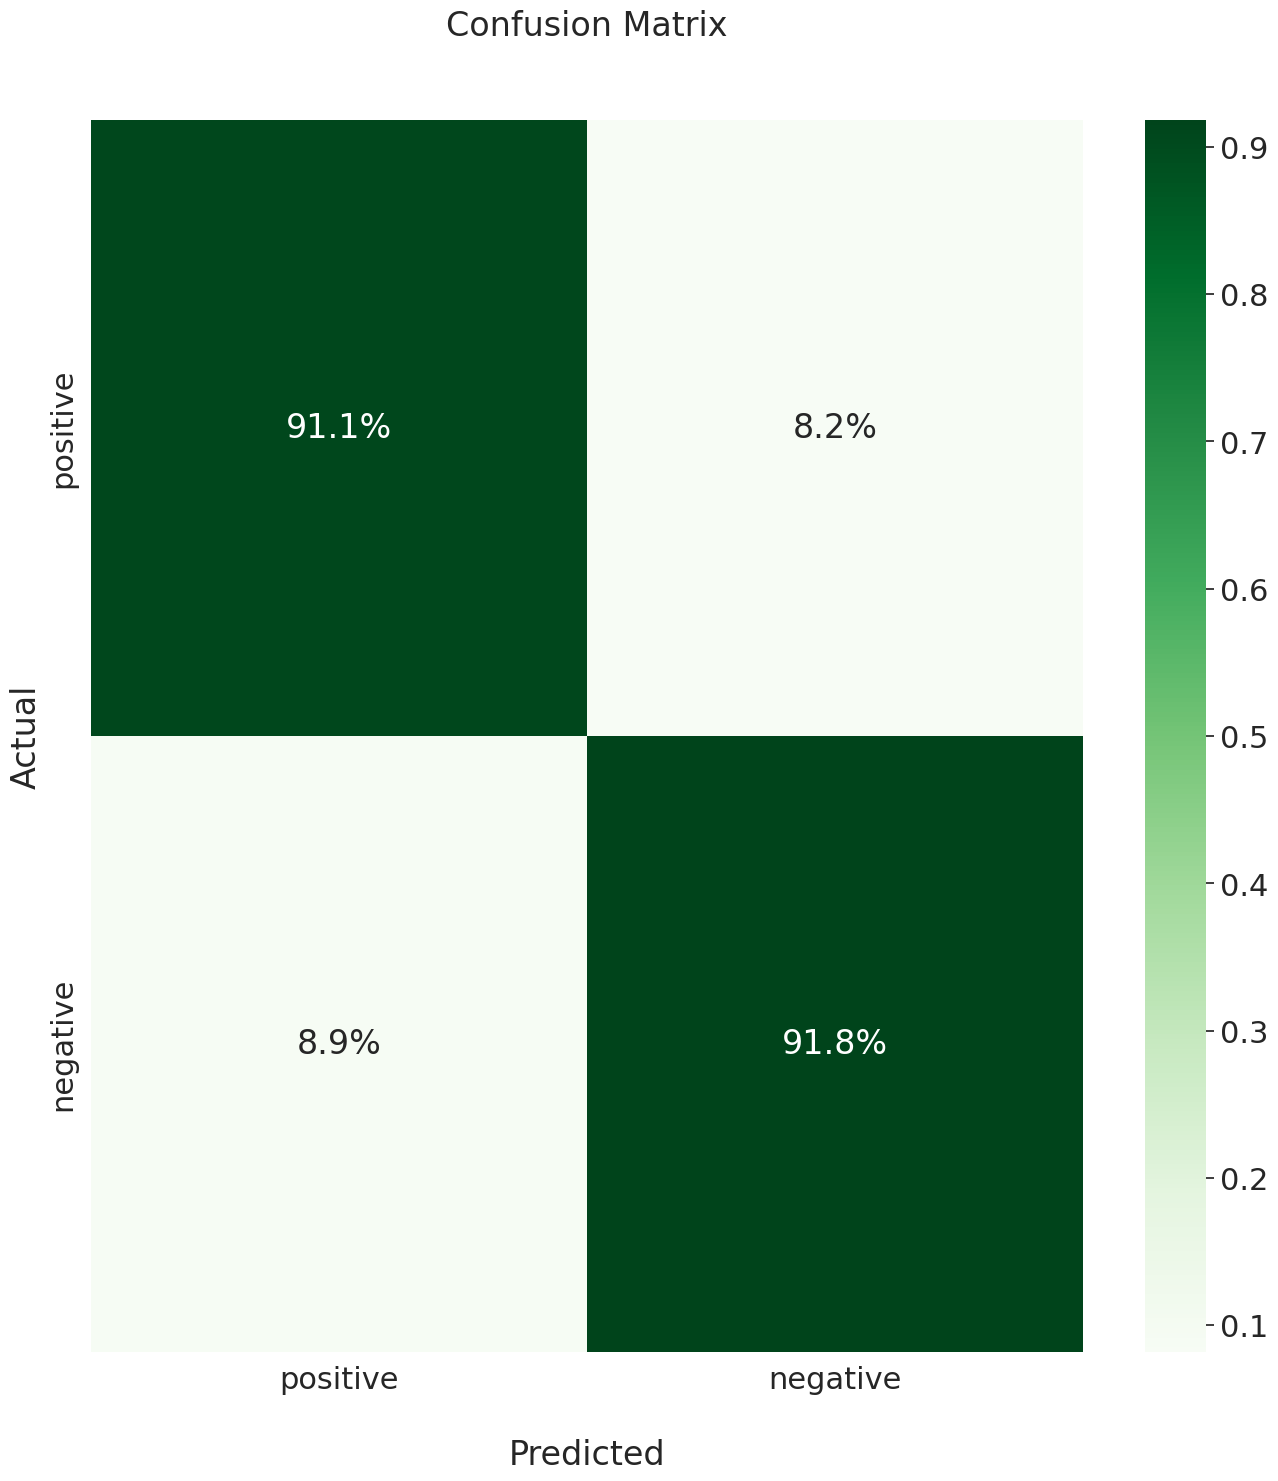

time: 638 ms (started: 2024-05-23 13:57:05 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
ax = sns.heatmap(cm_df/np.sum(cm_df), annot=True, fmt='.1%', cmap='Greens')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

ax.xaxis.set_ticklabels(id_to_sentiment.values())
ax.yaxis.set_ticklabels(id_to_sentiment.values())

plt.show()